In [1]:
!pip install monai

  Obtaining dependency information for monai from https://files.pythonhosted.org/packages/08/94/e8a7ba00dd0c7ce959648b562043bd22125d65f5e519e566c822f71bc437/monai-1.3.0-202310121228-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.4 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
from torchvision import models

import numpy as np
from PIL import Image
import os
from pathlib import Path
import huggingface_hub as hfh
import pandas as pd
import zipfile
import shutil
from tqdm.notebook import tqdm
import monai
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
hfh.login("INSERT TOKEN HERE")

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
panda_repo_id = "ain3007-project/panda-dataset-thumbnails-512-padded"
train_repo_id = "ain3007-project/dataset-thumbnails-512-padded"
test_repo_id = "ain3007-project/test-dataset-thumbnails-512-padded"

image_size = 512

In [5]:
def download_and_extract_images(repo_id, target_dir):
        print("started downloading files")
        images_zip_path = hfh.hf_hub_download(
            repo_id=repo_id,
            filename="images.zip",
            repo_type="dataset",
        )
        
        masks_zip_path = hfh.hf_hub_download(
            repo_id=repo_id,
            filename="masks.zip",
            repo_type="dataset",
        )
        
        metadata_path = hfh.hf_hub_download(
            repo_id=repo_id,
            filename="metadata.csv",
            repo_type="dataset",
        )
        
        os.makedirs(target_dir, exist_ok=True)
        shutil.copyfile(metadata_path, target_dir + "/metadata.csv")
        
        print("started extracting")
        with zipfile.ZipFile(images_zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)

        with zipfile.ZipFile(masks_zip_path, 'r') as zip_ref:
            zip_ref.extractall(target_dir)
        print("finished")

download_and_extract_images(panda_repo_id, "data/panda")
download_and_extract_images(train_repo_id, "data/train")
download_and_extract_images(test_repo_id, "data/test")

started downloading files


images.zip:   0%|          | 0.00/507M [00:00<?, ?B/s]

masks.zip:   0%|          | 0.00/24.3M [00:00<?, ?B/s]

metadata.csv:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

started extracting
finished
started downloading files


images.zip:   0%|          | 0.00/17.9M [00:00<?, ?B/s]

masks.zip:   0%|          | 0.00/319k [00:00<?, ?B/s]

metadata.csv:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

started extracting
finished
started downloading files


images.zip:   0%|          | 0.00/11.3M [00:00<?, ?B/s]

masks.zip:   0%|          | 0.00/307k [00:00<?, ?B/s]

metadata.csv:   0%|          | 0.00/8.85k [00:00<?, ?B/s]

started extracting
finished


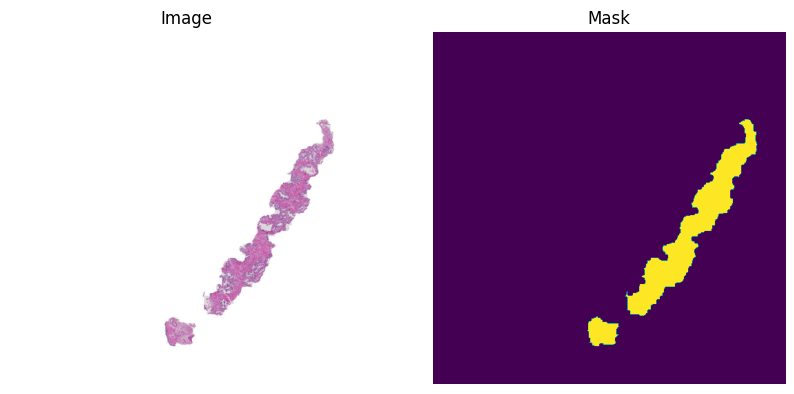

In [6]:
# imshow image and mask side by side
def imshow(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(plt.imread(image))
    ax1.set_title('Image')
    ax1.axis('off')
    ax2.imshow(plt.imread(mask))
    ax2.set_title('Mask')
    ax2.axis('off')
    plt.show()

imshow("data/panda/images/1.png", "data/panda/masks/1.png")


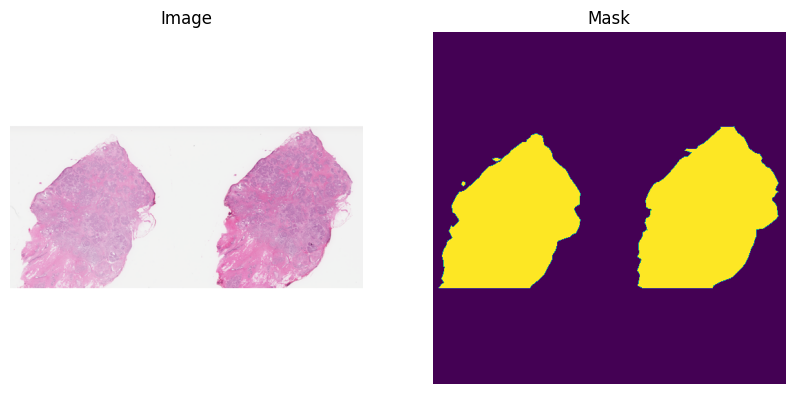

In [7]:
imshow("data/train/images/1.png", "data/train/masks/1.png")

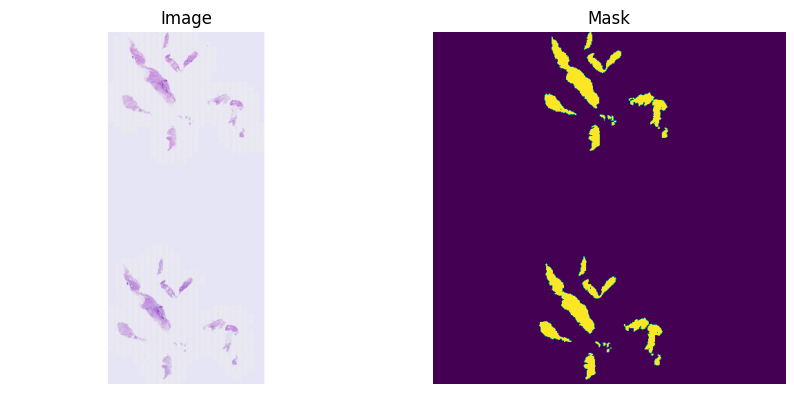

In [8]:
imshow("data/test/images/1.png", "data/test/masks/1.png")

In [9]:
np.unique(np.array(Image.open("data/test/masks/1.png")))

array([  0, 255], dtype=uint8)

In [10]:
panda_images = os.listdir("data/panda/images")
panda_masks = os.listdir("data/panda/masks")
train_images = os.listdir("data/train/images")
train_masks = os.listdir("data/train/masks")
test_images = os.listdir("data/test/images")
test_masks = os.listdir("data/test/masks")

# in train dataset there are some files with no mask and we should filter those
train_images = [i for i in train_images if i in train_masks]

panda_images = [f"data/panda/images/{image}" for image in panda_images]
panda_masks = [f"data/panda/masks/{mask}" for mask in panda_masks]
train_images = [f"data/train/images/{image}" for image in train_images]
train_masks = [f"data/train/masks/{mask}" for mask in train_masks]
test_images = [f"data/test/images/{image}" for image in test_images]
test_masks = [f"data/test/masks/{mask}" for mask in test_masks]


panda_images = list(zip(sorted(panda_images), sorted(panda_masks)))
train_images = list(zip(sorted(train_images), sorted(train_masks)))
test_images = list(zip(sorted(test_images), sorted(test_masks)))

# add panda images to train 
train_images = train_images + panda_images

# split train images into train and validation
train_images, valid_images = train_test_split(train_images, test_size=0.2, random_state=42)

In [11]:
train_transforms = A.Compose([
    A.Resize(height=image_size, width=image_size),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(),
#     A.Normalize(mean=[0.5], std=[0.5], always_apply=True),
    ToTensorV2(),
])

valid_transforms = A.Compose([
    A.Resize(height=image_size, width=image_size),
#     A.Normalize(mean=[0.5], std=[0.5]),
    ToTensorV2(),
])


In [12]:
# dataset
class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, images_list=None, transform=None):
        self.transform = transform
        self.images_list = images_list
    
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        image_path = self.images_list[idx][0]
        mask_path = self.images_list[idx][1]
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = np.array(image) / 255.0
        mask = np.array(mask) / 255.0
        
        image = image.astype(np.float32)
        mask = mask.astype(np.float32)  

        if self.transform is not None:
            try:
                result = self.transform(image=image, mask=mask)
            except ValueError:
                print("ERROR")
                print(image_path)
                print(mask_path)
                print(image.shape, mask.shape)
                raise ValueError("test")
            image = result["image"]
            mask = result["mask"]
        else:
            image = torch.from_numpy(image)
            mask = torch.from_numpy(mask)
            image = image.permute(2, 0, 1)

        mask = mask.unsqueeze(0)
        return image, mask


    
# train_dataset = SegmentationDataset(images_list=train_images)
# valid_dataset = SegmentationDataset(images_list=valid_images)
# test_dataset = SegmentationDataset(images_list=test_images)

train_dataset = SegmentationDataset(images_list=train_images, transform=train_transforms)
valid_dataset = SegmentationDataset(images_list=valid_images, transform=valid_transforms)
test_dataset = SegmentationDataset(images_list=test_images, transform=valid_transforms)


# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)


In [13]:
example_image, example_mask = train_dataset[0]
example_image.shape, example_mask.shape

(torch.Size([3, 512, 512]), torch.Size([1, 512, 512]))

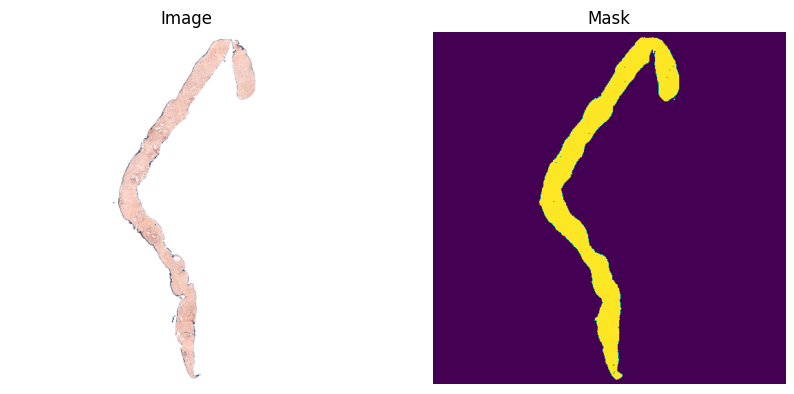

In [14]:
example_image, example_mask = train_dataset[50]
# plot image and mask side by side
def plot_image_mask(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image.permute(1, 2, 0))
    ax1.set_title('Image')
    ax1.axis('off')
    ax2.imshow(mask[0])
    ax2.set_title('Mask')
    ax2.axis('off')
    plt.show()

plot_image_mask(example_image, example_mask)

In [15]:
from monai.networks.nets import UNet          # unet model from monai (there are other models that you use with a single line)
import torch
import json

model_config = dict(
    spatial_dims=2,
    in_channels=3,
    out_channels=1,
    channels=[16, 32, 64, 128, 256, 512],  # Number of channels at each layer during contraction
    strides=(2, 2, 2, 2, 2),         # Strides for the convolutional layers
    num_res_units=4,                 # Number of residual units
    dropout=0.15,                    # Dropout rate to prevent overfitting)
)

model = UNet(**model_config)



with open('model_config.json', 'w') as fp:
    json.dump(model_config, fp)


model(torch.randn(4, 3, 512, 512)).shape # torch.Size([4, 1, 512, 512])


torch.Size([4, 1, 512, 512])

In [16]:
model

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.15, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (adn): ADN(
            (N): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_

In [17]:
# train
critetion = nn.BCEWithLogitsLoss()
loss = monai.losses.DiceLoss(sigmoid=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
num_epochs = 15
history = {
    "train_loss": [],
    "valid_loss": [],
}

best_loss = float("inf")

for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0
    model.train()
    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = critetion(output, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    history["train_loss"].append(train_loss)

    model.eval()
    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            images, masks = images.to(device), masks.to(device)
            output = model(images)
            loss = critetion(output, masks)
            valid_loss += loss.item()
        valid_loss /= len(valid_loader)
        history["valid_loss"].append(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch: {epoch+1}/{num_epochs}, train_loss: {train_loss}, valid_loss: {valid_loss}")

  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 1/15, train_loss: 0.20425766035707077, valid_loss: 0.07380044308525545


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 2/15, train_loss: 0.06460034520346292, valid_loss: 0.06077371817082167


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 3/15, train_loss: 0.05158740078688276, valid_loss: 0.045363427974559646


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 4/15, train_loss: 0.04211074821754654, valid_loss: 0.03906224216851923


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 5/15, train_loss: 0.03612571423233993, valid_loss: 0.032346518565383224


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 6/15, train_loss: 0.030272074135327936, valid_loss: 0.027808172790402614


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 7/15, train_loss: 0.028318382425541282, valid_loss: 0.024996543861925603


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 8/15, train_loss: 0.026181883731570117, valid_loss: 0.024165714038880886


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 9/15, train_loss: 0.024736541438267215, valid_loss: 0.021772715690787193


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 10/15, train_loss: 0.025019633550894947, valid_loss: 0.02237379287748977


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 11/15, train_loss: 0.02542402067935312, valid_loss: 0.03827530966588744


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 12/15, train_loss: 0.025181658223015643, valid_loss: 0.021764078612128892


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 13/15, train_loss: 0.02321794221060202, valid_loss: 0.021390596325336783


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 14/15, train_loss: 0.02266995122065294, valid_loss: 0.02128170876660281


  0%|          | 0/1078 [00:00<?, ?it/s]

  0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 15/15, train_loss: 0.02330175312132279, valid_loss: 0.0236996670426042


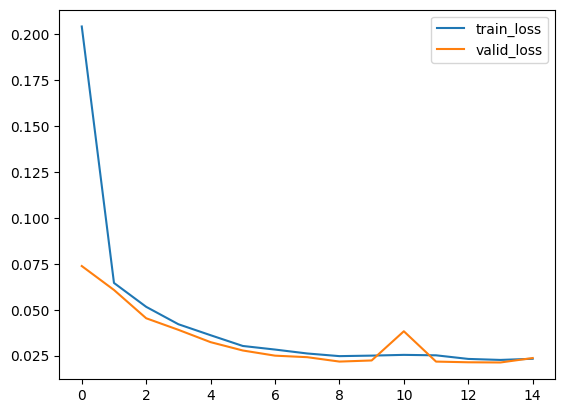

In [19]:
# plot losses
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["valid_loss"], label="valid_loss")
plt.legend()
plt.show()

In [20]:
# load best model
model.load_state_dict(torch.load("best_model.pth"))

<All keys matched successfully>

In [21]:
def plot_batch_images(images, masks, preds, fig_scale=3):
    batch_size = images.shape[0]
    fig, axes = plt.subplots(batch_size, 3, figsize=(fig_scale*3, fig_scale*batch_size))
    for i in range(batch_size):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))
        axes[i, 0].set_title('Image')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(masks[i][0])
        axes[i, 1].set_title('Mask')
        axes[i, 1].axis('off')
        axes[i, 2].imshow(preds[i][0])
        axes[i, 2].set_title('Prediction')
        axes[i, 2].axis('off')
    plt.show()

  0%|          | 0/14 [00:00<?, ?it/s]

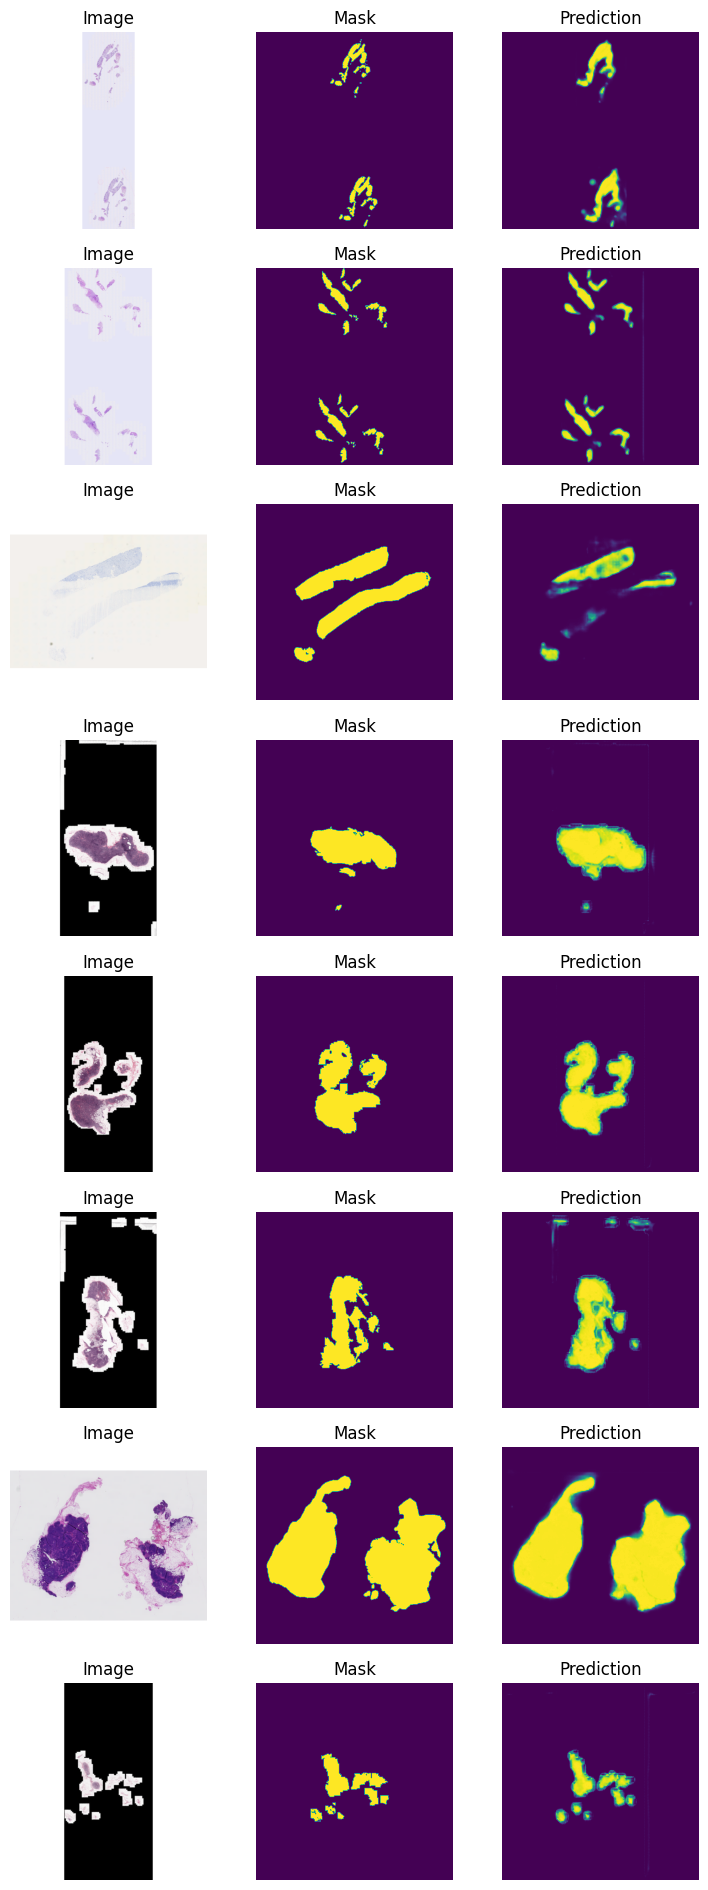

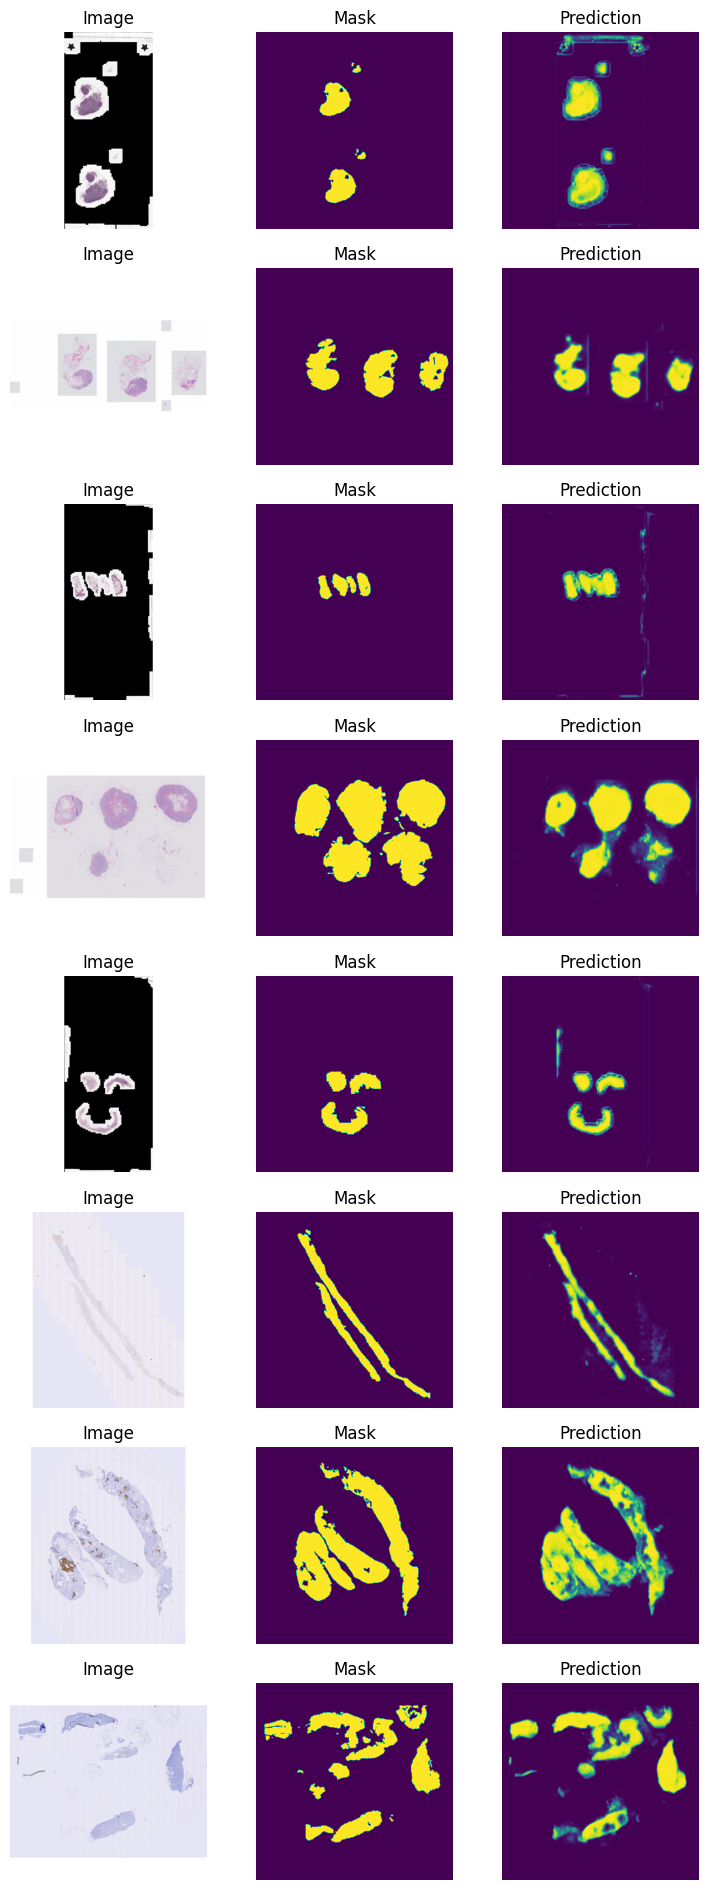

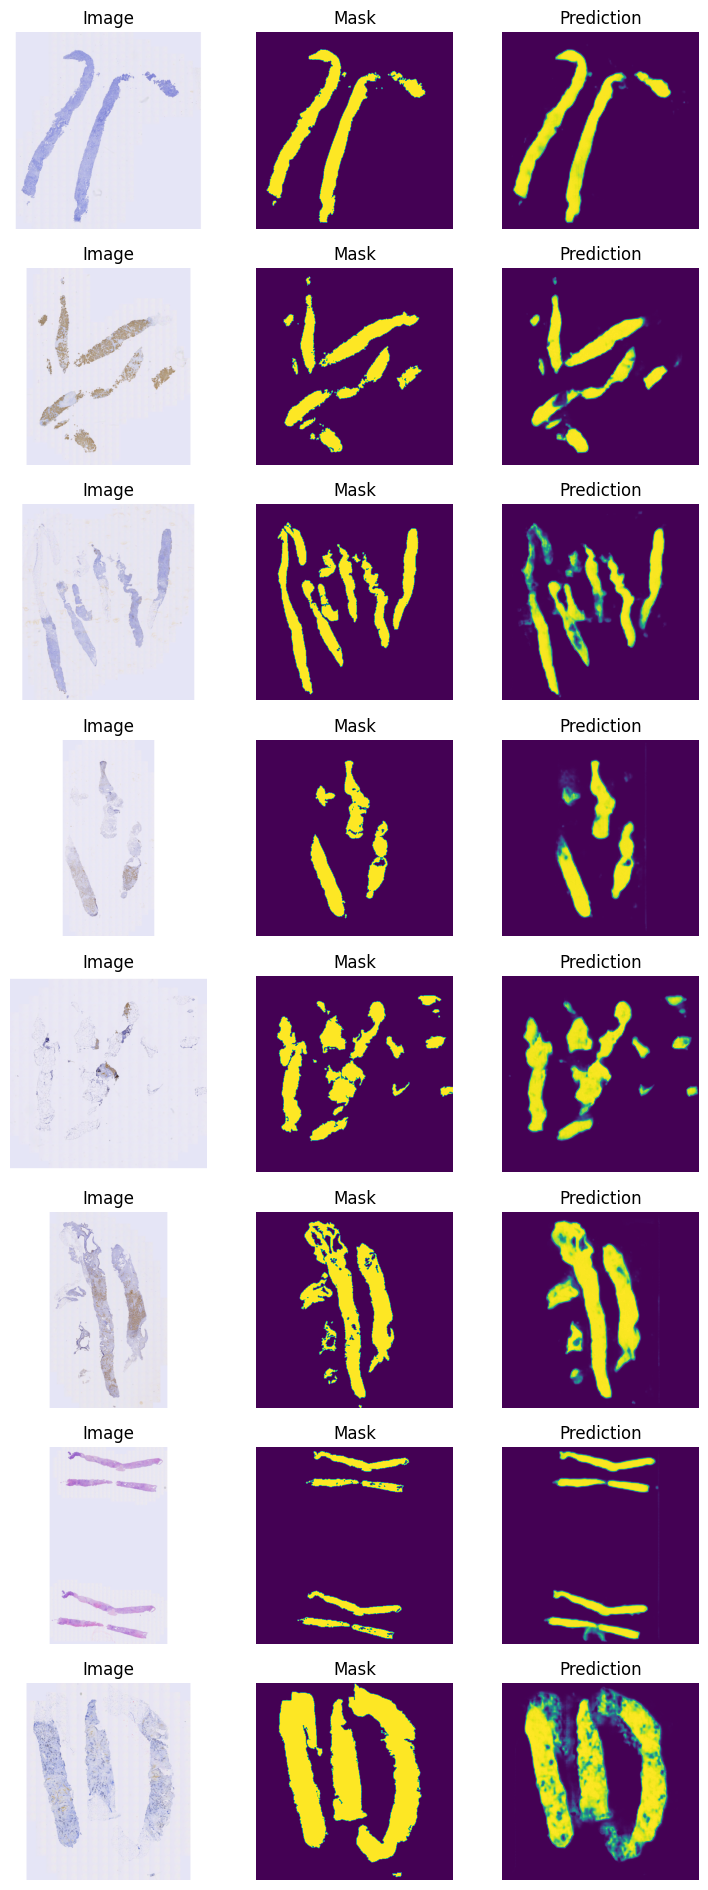

test_loss: 0.06027714954689145


In [22]:
# test
test_score = 0
model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(tqdm(test_loader)):
        images, masks = images.to(device), masks.to(device)
        output = model(images)
        loss = critetion(output, masks)
        test_score += loss.item()

        if idx < 3:
            plot_batch_images(images.cpu(), masks.cpu(), torch.sigmoid(output.cpu()))
    test_score /= len(test_loader)
print(f"test_loss: {test_score}")